# Load the dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def load_dataset(file_path):
    assen_data = pd.read_csv(file_path)
    return assen_data
assen_data = load_dataset("/content/drive/MyDrive/Assignments/Processed_Assen_RS_data.csv")
size = (172, 284)
assen_data.head()




,Unnamed: 0,Longitude,Latitude,Band1,Band2,Band3,Band4,Band5,Band6,Band7
0,0,27.564250,-25.105965,188,227,363,406,750,709,440
1,1,27.564548,-25.105963,126,144,215,166,917,479,232
2,2,27.564845,-25.105962,141,187,421,310,2263,947,438
3,3,27.565143,-25.105961,111,170,402,291,2558,1154,562
4,4,27.565440,-25.105960,232,365,658,779,2409,2199,1319


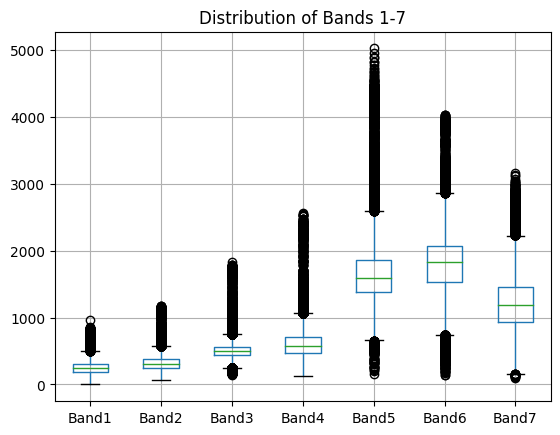

In [ ]:
#Visualize the distribution of values
assen_data[['Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7']].boxplot()
plt.title('Distribution of Bands 1-7')
plt.show()

In [ ]:
#machine learning workflow to reconstruct bands 4, 5, 6 and extract the residuals

#Extract the original bands for reconstruction
original_bands = assen_data[['Band1', 'Band2', 'Band3', 'Band7']]
original_bands

,Band1,Band2,Band3,Band7
0,188,227,363,440
1,126,144,215,232
2,141,187,421,438
3,111,170,402,562
4,232,365,658,1319
...,...,...,...,...
48843,381,449,677,1749
48844,408,483,720,2068
48845,364,414,584,2039
48846,387,415,565,1867


In [ ]:
#Data transformations (Standardization and Normalization)
scaler = MinMaxScaler()  # Use MinMaxScaler instead of StandardScaler
X_scaled = scaler.fit_transform(original_bands)
X_scaled

array([[0.19421488, 0.14878269, 0.12700297, 0.11060209],
       [0.13016529, 0.07394049, 0.03916914, 0.04253927],
       [0.14566116, 0.11271416, 0.16142433, 0.10994764],
       ...,
       [0.37603306, 0.31740307, 0.25816024, 0.63383508],
       [0.39979339, 0.31830478, 0.24688427, 0.57755236],
       [0.42975207, 0.33633904, 0.25459941, 0.52879581]])

In [ ]:
# Perform PCA transformation on the scaled original bands
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reconstructed_bands = pca.fit_transform(X_scaled)
reconstructed_bands

array([[-2.68800801e-01,  8.50547377e-02,  5.93387388e-02],
       [-4.10666105e-01,  4.29641396e-02,  7.05906849e-02],
       [-2.94405703e-01,  8.52964396e-02, -2.99882558e-03],
       ...,
       [ 2.88294504e-01, -1.11333483e-01,  1.82117445e-04],
       [ 2.57735429e-01, -7.55428005e-02,  3.98717647e-02],
       [ 2.50024215e-01, -2.62443416e-02,  7.36755007e-02]])

In [ ]:
#Calculate residuals (difference between original and reconstructed bands)
residuals = X_scaled - pca.inverse_transform(reconstructed_bands)
residuals

array([[ 2.17478336e-03, -3.42662311e-03,  1.69644538e-03,
        -1.31601655e-04],
       [-3.95211423e-04,  6.22701377e-04, -3.08285691e-04,
         2.39152452e-05],
       [ 1.07630628e-02, -1.69584522e-02,  8.39575492e-03,
        -6.51300216e-04],
       ...,
       [-1.05263631e-03,  1.65855044e-03, -8.21111671e-04,
         6.36976917e-05],
       [ 3.08674007e-03, -4.86351654e-03,  2.40781956e-03,
        -1.86786467e-04],
       [ 5.65400327e-03, -8.90853711e-03,  4.41041986e-03,
        -3.42138073e-04]])

In [ ]:
#Add residuals to the dataset
assen_data['Residual4'] = residuals[:, 0]
assen_data['Residual5'] = residuals[:, 1]
assen_data['Residual6'] = residuals[:, 2]

In [ ]:
#Split the data into features (X) and residuals for each band
X = X_scaled
y_residuals4 = residuals[:, 0]
y_residuals5 = residuals[:, 1]
y_residuals6 = residuals[:, 2]

In [ ]:
#Train a Random Forest regressor for each band to predict residuals
regressor4 = RandomForestRegressor(n_estimators=100, random_state=42)
regressor4.fit(X, y_residuals4)

RandomForestRegressor(random_state=42)

In [ ]:
regressor5 = RandomForestRegressor(n_estimators=100, random_state=42)
regressor5.fit(X, y_residuals5)

RandomForestRegressor(random_state=42)

In [ ]:
regressor6 = RandomForestRegressor(n_estimators=100, random_state=42)
regressor6.fit(X, y_residuals6)

RandomForestRegressor(random_state=42)

In [ ]:
#Make predictions on the entire dataset for each band
assen_data['PredictedResidual4'] = regressor4.predict(X)
assen_data['PredictedResidual5'] = regressor5.predict(X)
assen_data['PredictedResidual6'] = regressor6.predict(X)

In [ ]:
#Reshape PredictedResidual4, PredictedResidual5, PredictedResidual6
predicted_residual4 = assen_data['PredictedResidual4'].values.reshape(-1, 1)
predicted_residual5 = assen_data['PredictedResidual5'].values.reshape(-1, 1)
predicted_residual6 = assen_data['PredictedResidual6'].values.reshape(-1, 1)

#Check shapes before adding
print('Original Band4 shape:', assen_data['Band4'].shape)
print('PredictedResidual4 shape:', predicted_residual4.shape)

#Add the original bands with the reshaped predicted residuals
assen_data['ReconstructedBand4'] = assen_data['Band4'].values + predicted_residual4.flatten()
assen_data['ReconstructedBand5'] = assen_data['Band5'].values + predicted_residual5.flatten()
assen_data['ReconstructedBand6'] = assen_data['Band6'].values + predicted_residual6.flatten()

#Check shapes after adding
print('ReconstructedBand4 shape:', assen_data['ReconstructedBand4'].shape)
print('ReconstructedBand5 shape:', assen_data['ReconstructedBand5'].shape)
print('ReconstructedBand6 shape:', assen_data['ReconstructedBand6'].shape)

Original Band4 shape: (48848,)
PredictedResidual4 shape: (48848, 1)
ReconstructedBand4 shape: (48848,)
ReconstructedBand5 shape: (48848,)
ReconstructedBand6 shape: (48848,)


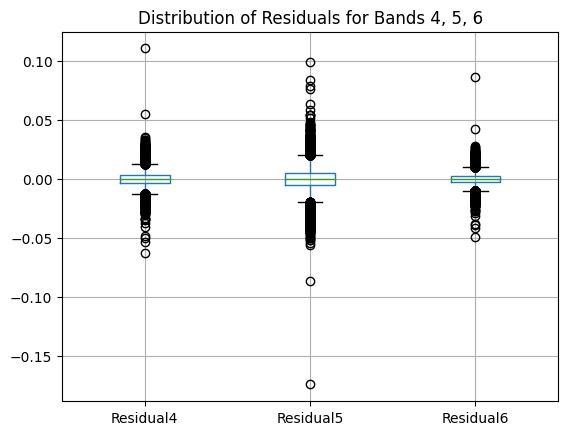

In [ ]:
#Visualize the distribution of residuals
assen_data[['Residual4', 'Residual5', 'Residual6']].boxplot()
plt.title('Distribution of Residuals for Bands 4, 5, 6')
plt.show()

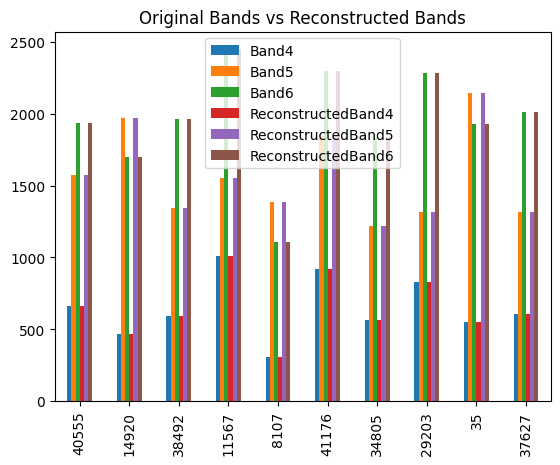

In [ ]:
#Visualize the reconstructed bands
assen_data[['Band4', 'Band5', 'Band6', 'ReconstructedBand4', 'ReconstructedBand5', 'ReconstructedBand6']].sample(10).plot(kind='bar')
plt.title('Original Bands vs Reconstructed Bands')
plt.show()

In [ ]:
#lists of similar types of metadata to make referencing the data easier
coord_names = ['Longitude', 'Latitude']
bands = ['Band1', 'Band2','Band3', 'Band4', 'Band5', 'Band6', 'Band7']


assen_data['Latitude'] = pd.to_numeric(assen_data['Latitude'], errors='coerce') #convert latitude to numeric values
assen_data['Longitude'] = pd.to_numeric(assen_data['Longitude'], errors='coerce') #convert longitude to numeric values



for band in bands:
    assen_data[band] = np.abs(pd.to_numeric(assen_data[band], errors='coerce')) #make all chemical composition to be numeric


assen_data.describe()

,Unnamed: 0,Longitude,Latitude,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Residual4,Residual5,Residual6,PredictedResidual4,PredictedResidual5,PredictedResidual6,ReconstructedBand4,ReconstructedBand5,ReconstructedBand6
count,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,48848.000000,4.884800e+04,4.884800e+04,4.884800e+04,4.884800e+04,4.884800e+04,4.884800e+04,48848.000000,48848.000000,48848.000000
mean,24423.500000,27.606466,-25.128960,251.722547,316.526327,509.547433,609.615419,1648.147539,1801.414490,1216.814609,-2.836469e-18,4.218338e-18,-2.400089e-18,-2.791378e-07,3.483568e-07,-6.095056e-09,609.615419,1648.147540,1801.414490
std,14101.347312,0.024398,0.013452,94.493587,106.311331,145.656643,238.682890,446.999961,469.584012,432.462650,5.292617e-03,8.339131e-03,4.128519e-03,5.080867e-03,8.006619e-03,3.963387e-03,238.682606,446.997499,469.583938
min,0.000000,27.564250,-25.152291,0.000000,62.000000,149.000000,121.000000,150.000000,141.000000,102.000000,-6.259060e-02,-1.740871e-01,-4.882396e-02,-4.534431e-02,-1.085861e-01,-3.538843e-02,121.000558,150.004865,141.002298
25%,12211.750000,27.585356,-25.140607,186.000000,248.000000,436.000000,467.000000,1382.000000,1539.000000,937.750000,-3.208100e-03,-4.919168e-03,-2.502487e-03,-3.144250e-03,-4.844870e-03,-2.451424e-03,467.000712,1382.002000,1539.000200
50%,24423.500000,27.606466,-25.128958,245.000000,312.000000,498.000000,577.000000,1585.000000,1830.000000,1196.000000,-3.258728e-05,5.134503e-05,-2.541979e-05,-2.544912e-05,4.210224e-05,-1.951625e-05,576.990821,1585.003313,1829.999292
75%,36635.250000,27.627580,-25.117309,312.000000,377.000000,562.000000,706.000000,1865.000000,2070.000000,1454.000000,3.122060e-03,5.054734e-03,2.435371e-03,3.076671e-03,4.953758e-03,2.400243e-03,705.997349,1864.990760,2070.008883
max,48847.000000,27.648697,-25.105620,968.000000,1171.000000,1834.000000,2558.000000,5025.000000,4031.000000,3158.000000,1.104883e-01,9.861873e-02,8.618668e-02,6.887847e-02,7.193896e-02,5.369577e-02,2557.997663,5024.955665,4030.998099


In [ ]:
r = assen_data['Band4']
g = assen_data['Band3']
b = assen_data['Band2']
B1 = assen_data['Band1']
nir = assen_data['Band5']
SWIR1 = assen_data['Band6']
SWIR2 = assen_data['Band7']


ferrous_minerals_ratio = (SWIR1/nir).values.reshape((172, 284))#High values in band ratio 4/2 are useful to detect the charge transfer absorption related to ferric iron oxides
ferric_iron_oxide = ((r+SWIR1)/nir).values.reshape((172, 284)) # are useful to detect the crystal-field absorption of ferric iron oxide
clay_minerals_ratio = (SWIR1/SWIR2).values.reshape((172, 284))


#False color Composite (FCC) 753
ndvi = (nir.astype(float)-r.astype(float))/(nir+r) #Normalized Difference Vegetation Index (NDVI)
ndvi = ndvi.values.reshape((172, 284))
ndwi = (nir.astype(float)-g.astype(float))/(nir+g) #Normalized Difference Water Index (NDWI)
ndwi = ndwi.values.reshape((172, 284))
B42  = r/b
B42.values.reshape((172, 284))
B57  = nir/SWIR1 # this should be nir/SWIR2
B57.values.reshape((172, 284))
B54 = nir/r
B54.values.reshape((172, 284))
#Landsat 8 image ratios (4/2, 5/7, 5/4) in RGB recognized the distribution of iron ore (red-yellow color range)


#543 distinguish vegitation
#764 urban area
#Bathymetric (4, 3, 1)
#Geology (7, 6, 2)
#Agriculture (6, 5, 2)
#Short-Wave Infrared (7, 6 4)
#Color Infrared (5, 4, 3)
#Natural Color (4, 3, 2)




'''B1 = "Band 1",
   B2 = "Blue",
   B3 = "Green",
   B4 = "Red",
   B5 = "NIR",
   B6 = "SWIR1",
   B7 = "SWIR2"]

'''

'B1 = "Band 1", \n   B2 = "Blue", \n   B3 = "Green", \n   B4 = "Red",\n   B5 = "NIR", \n   B6 = "SWIR1", \n   B7 = "SWIR2"]\n\n'

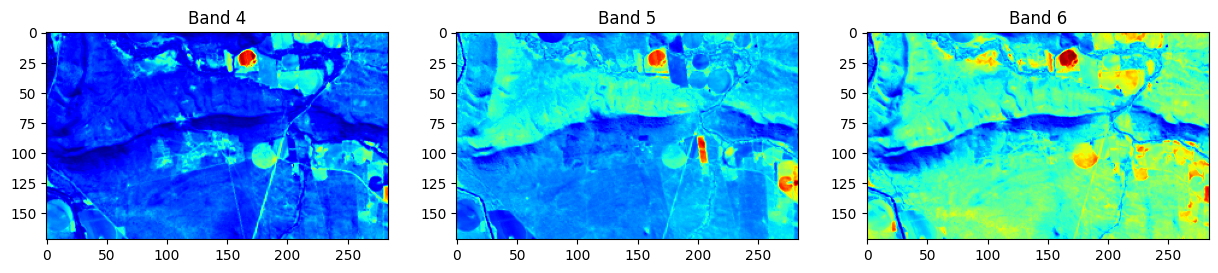

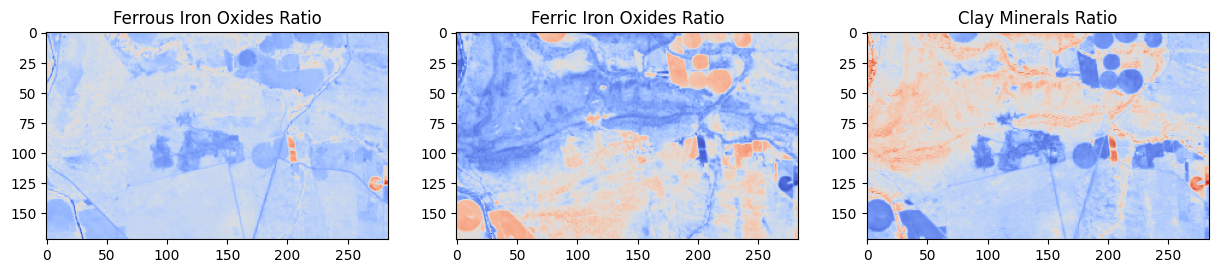

In [ ]:
#Define bands
band4 = assen_data['Band4'].values.reshape((172, 284))
band5 = assen_data['Band5'].values.reshape((172, 284))
band6 = assen_data['Band6'].values.reshape((172, 284))
band7 = assen_data['Band7'].values.reshape((172, 284))

#Plot bands 4, 5, and 6
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(band4, cmap='jet')
axes[0].set_title('Band 4')

axes[1].imshow(band5, cmap='jet')
axes[1].set_title('Band 5')

axes[2].imshow(band6, cmap='jet')
axes[2].set_title('Band 6')

plt.show()

#Calculate band ratios
ferrous_minerals_ratio = band6 / band4
ferric_iron_oxide = (band4 + band6) / band5
clay_minerals_ratio = band6 / band7

#Plot band ratio images for ferrous and ferric iron oxides, and clay
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ferrous_minerals_ratio, cmap='coolwarm')
axes[0].set_title('Ferrous Iron Oxides Ratio')

axes[1].imshow(ferric_iron_oxide, cmap='coolwarm')
axes[1].set_title('Ferric Iron Oxides Ratio')

axes[2].imshow(clay_minerals_ratio, cmap='coolwarm')
axes[2].set_title('Clay Minerals Ratio')

plt.show()

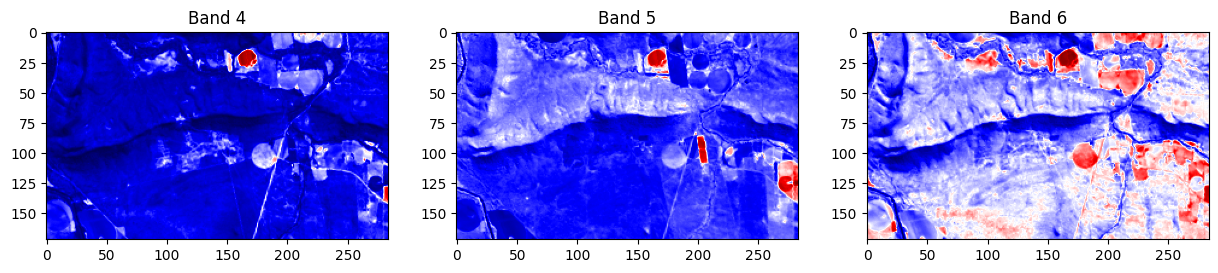

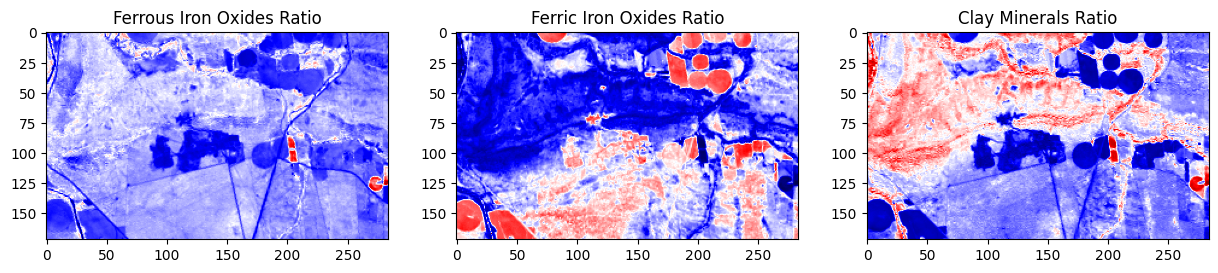

In [ ]:
# Define bands
band4 = assen_data['Band4'].values.reshape((172, 284))
band5 = assen_data['Band5'].values.reshape((172, 284))
band6 = assen_data['Band6'].values.reshape((172, 284))
band7 = assen_data['Band7'].values.reshape((172, 284))

# Plot bands 4, 5, and 6
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(band4, cmap='seismic')
axes[0].set_title('Band 4')

axes[1].imshow(band5, cmap='seismic')
axes[1].set_title('Band 5')

axes[2].imshow(band6, cmap='seismic')
axes[2].set_title('Band 6')

plt.show()

# Calculate band ratios
ferrous_minerals_ratio = band6 / band4
ferric_iron_oxide = (band4 + band6) / band5
clay_minerals_ratio = band6 / band7

# Plot band ratio images for ferrous and ferric iron oxides, and clay
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ferrous_minerals_ratio, cmap='seismic')
axes[0].set_title('Ferrous Iron Oxides Ratio')

axes[1].imshow(ferric_iron_oxide, cmap='seismic')
axes[1].set_title('Ferric Iron Oxides Ratio')

axes[2].imshow(clay_minerals_ratio, cmap='seismic')
axes[2].set_title('Clay Minerals Ratio')

plt.show()


Best model for Band4: RandomForest
R2 score for Band4: 0.9790342473093404
Best model for Band5: RandomForest
R2 score for Band5: 0.770949360503257
Best model for Band6: RandomForest
R2 score for Band6: 0.9301959233195504


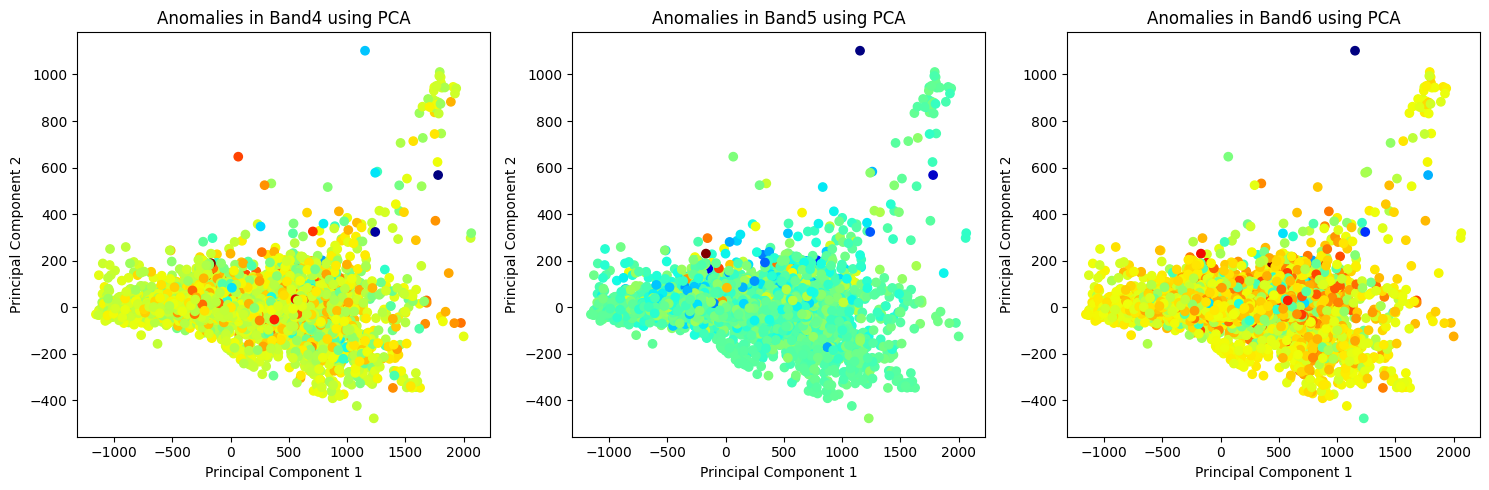

In [ ]:
#Define bands and target variables
bands = ['Band4', 'Band5', 'Band6']
target_variables = ['Reconstructed_Band4', 'Reconstructed_Band5', 'Reconstructed_Band6']

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(),
    'kNN': KNeighborsRegressor(),
    'SVM': SVR()
}

# Initialize PCA
pca = PCA(n_components=3)

# Set up subplots
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5))

# Iterate over bands
for i, (band, target_variable) in enumerate(zip(bands, target_variables)):
    # Extract features and target variable
    X = assen_data[['Band1', 'Band2', 'Band3', 'Band7']].values  # Adjust bands as needed
    y = assen_data[band].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_model = None
    best_score = -np.inf

    # Iterate over models and find the best one
    for model_name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        mean_score = np.mean(scores)

        if mean_score > best_score:
            best_score = mean_score
            best_model = model_name

    print(f"Best model for {band}: {best_model}")

    # Train the best model on the full training set
    best_model = models[best_model]
    best_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    print(f"R2 score for {band}: {r2}")

    # Apply PCA
    X_pca = pca.fit_transform(X_test)

    # Plot the anomalies using PCA
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=y_test - y_pred, cmap='jet')
    axes[i].set_title(f"Anomalies in {band} using PCA")
    axes[i].set_xlabel('Principal Component 1')
    axes[i].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

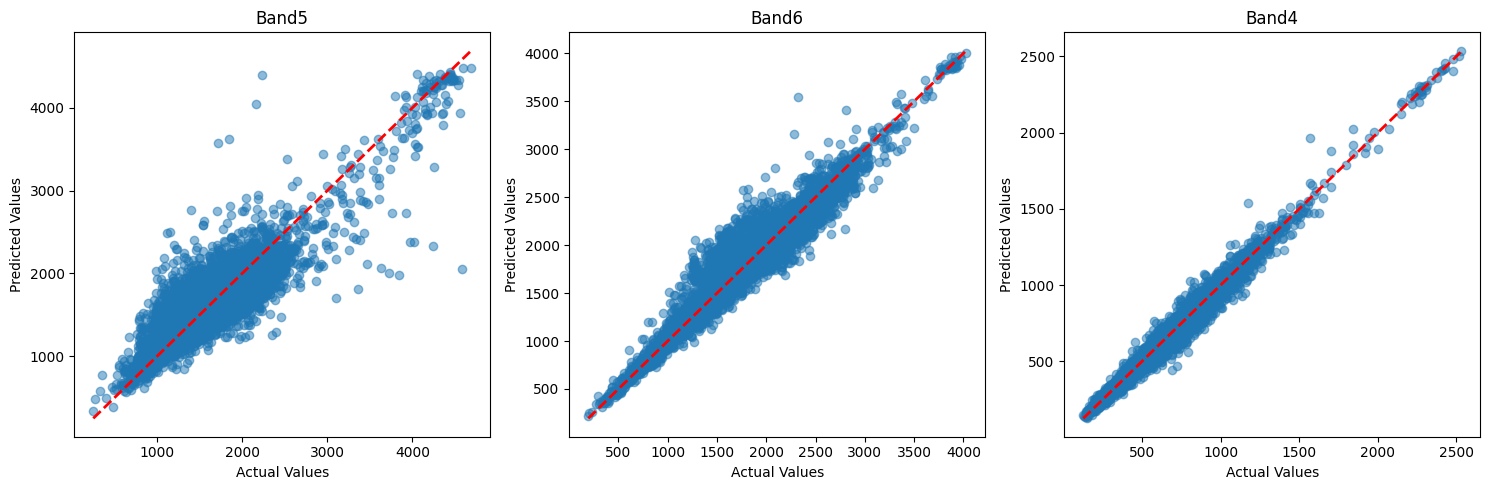

In [ ]:
#Define bands and corresponding CoD values
bands = ['Band5', 'Band6', 'Band4']
cod_values = [0.773, 0.930, 0.979]

#Initialize models with parameters from Table 3
models = {
    'RandomForest_Band5': RandomForestRegressor(),
    'RandomForest_Band6': RandomForestRegressor(),
    'RandomForest_Band4': RandomForestRegressor(),
}

#Set up subplots
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5))

#Iterate over bands in the order of increasing CoD
for i, (band, cod_value) in enumerate(sorted(zip(bands, cod_values), key=lambda x: x[1])):
    #Extract features and target variable
    X = assen_data[['Band1', 'Band2', 'Band3', 'Band7']].values
    y = assen_data[band].values

    #Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Initialize and train the model
    model = models[f'RandomForest_{band}']
    model.fit(X_train, y_train)

    #Make predictions
    y_pred = model.predict(X_test)

    #Plot Prediction versus Actual
    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)
    axes[i].set_title(f'{band}')
    axes[i].set_xlabel('Actual Values')
    axes[i].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

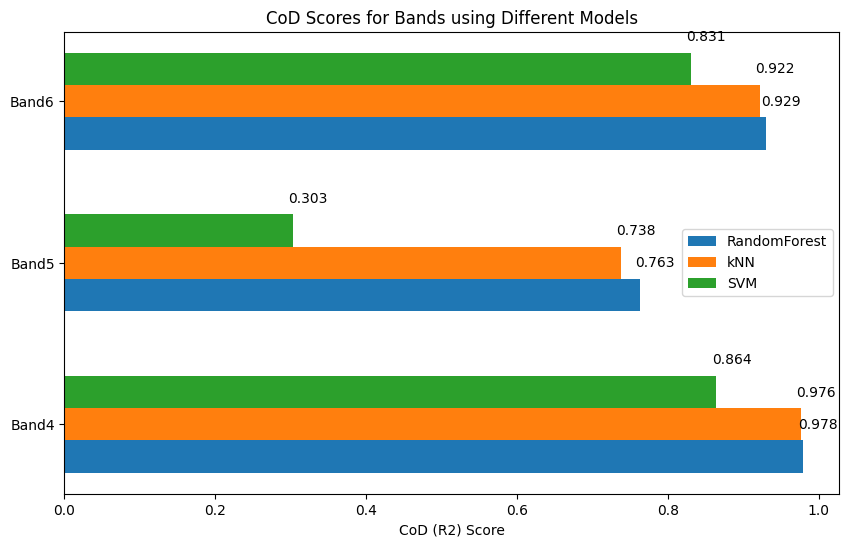

In [ ]:
# Define bands and target variables
bands = ['Band4', 'Band5', 'Band6']

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(),
    'kNN': KNeighborsRegressor(),
    'SVM': SVR()
}

# Initialize arrays to store CoD scores
cod_scores = np.zeros((len(bands), len(models)))

# Iterate over bands
for i, band in enumerate(bands):
    # Extract features and target variable
    X = assen_data[['Band1', 'Band2', 'Band3', 'Band7']].values
    y = assen_data[band].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Iterate over models and find the best one
    for j, (model_name, model) in enumerate(models.items()):
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        mean_score = np.mean(scores)

        cod_scores[i, j] = mean_score

# Plot CoD scores horizontally with values on bars
fig, ax = plt.subplots(figsize=(10, 6))

for i, band in enumerate(bands):
    for j, (model_name, _) in enumerate(models.items()):
        value = cod_scores[i, j]
        ax.text(value + 0.02, i + j * 0.2, f'{value:.3f}', color='black', ha='center', va='center')

ax.barh(np.arange(len(bands)) - 0.2, cod_scores[:, 0], 0.2, label='RandomForest')
ax.barh(np.arange(len(bands)), cod_scores[:, 1], 0.2, label='kNN')
ax.barh(np.arange(len(bands)) + 0.2, cod_scores[:, 2], 0.2, label='SVM')

ax.set_yticks(np.arange(len(bands)))
ax.set_yticklabels(bands)
ax.set_xlabel('CoD (R2) Score')
ax.set_title('CoD Scores for Bands using Different Models')
ax.legend()

plt.show()

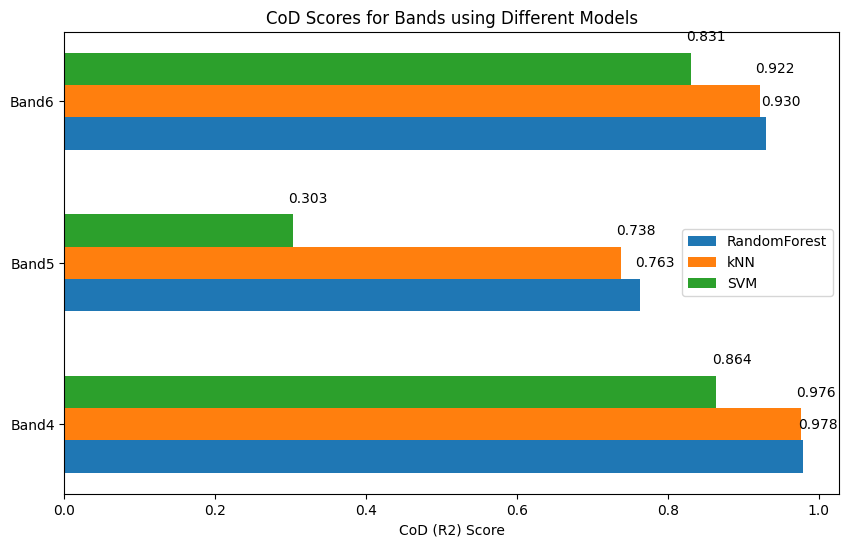

In [ ]:
# Initialize arrays to store CoD scores
cod_scores = np.zeros((len(bands), len(models)))

# Iterate over bands
for i, band in enumerate(bands):
    # Extract features and target variable
    X = assen_data[['Band1', 'Band2', 'Band3', 'Band7']].values
    y = assen_data[band].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Iterate over models and find the best one
    for j, (model_name, model) in enumerate(models.items()):
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        mean_score = np.mean(scores)

        cod_scores[i, j] = mean_score

# Plot CoD scores horizontally with values on bars
fig, ax = plt.subplots(figsize=(10, 6))

for i, band in enumerate(bands):
    for j, (model_name, _) in enumerate(models.items()):
        value = cod_scores[i, j]
        ax.text(value + 0.02, i + j * 0.2, f'{value:.3f}', color='black', ha='center', va='center')

ax.barh(np.arange(len(bands)) - 0.2, cod_scores[:, 0], 0.2, label='RandomForest')
ax.barh(np.arange(len(bands)), cod_scores[:, 1], 0.2, label='kNN')
ax.barh(np.arange(len(bands)) + 0.2, cod_scores[:, 2], 0.2, label='SVM')

ax.set_yticks(np.arange(len(bands)))
ax.set_yticklabels(bands)
ax.set_xlabel('CoD (R2) Score')
ax.set_title('CoD Scores for Bands using Different Models')
ax.legend()

plt.show()

Best model for Band4: RandomForest
R2 score for Band4: 0.9790449200979996
Best model for Band5: RandomForest
R2 score for Band5: 0.7707541336370977
Best model for Band6: RandomForest
R2 score for Band6: 0.9302897175657691


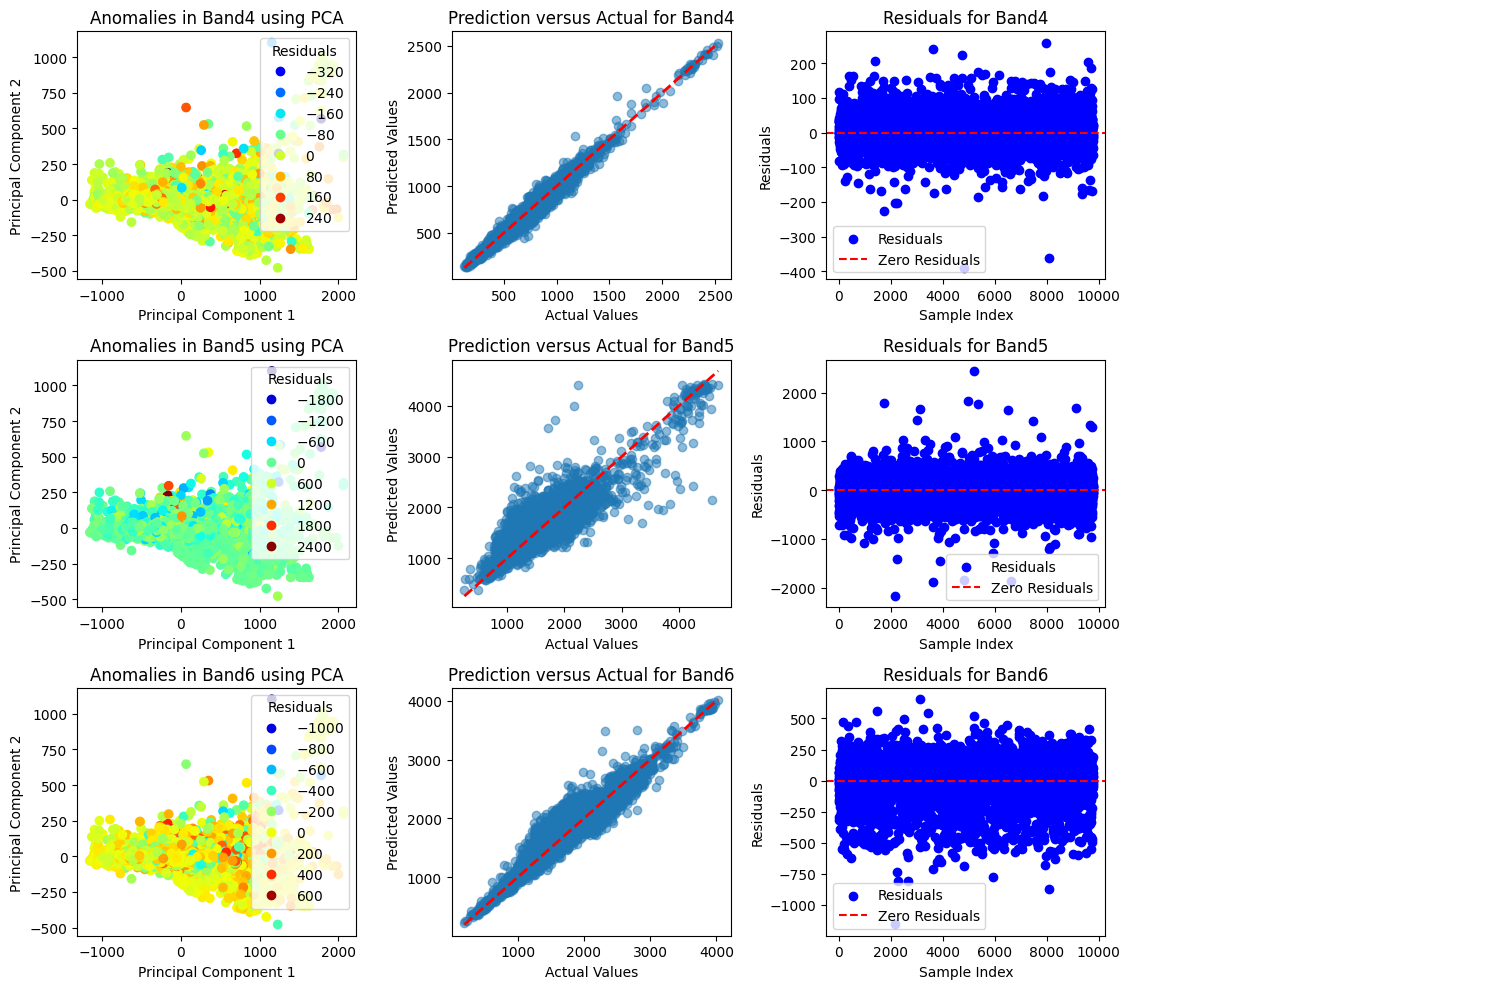

In [ ]:
#Define bands and target variables
bands = ['Band4', 'Band5', 'Band6']
target_variables = ['Reconstructed_Band4', 'Reconstructed_Band5', 'Reconstructed_Band6']

#Initialize models
models = {
    'RandomForest': RandomForestRegressor(),
    'kNN': KNeighborsRegressor(),
    'SVM': SVR()
}

#Initialize PCA
pca = PCA(n_components=3)

#Set up subplots
fig, axes = plt.subplots(3, len(bands) + 1, figsize=(15, 10))

#Iterate over bands
for i, (band, target_variable) in enumerate(zip(bands, target_variables)):
    # Extract features and target variable
    X = assen_data[['Band1', 'Band2', 'Band3', 'Band7']].values  # Adjust bands as needed
    y = assen_data[band].values

    #Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_model = None
    best_score = -np.inf

    #Iterate over models and find the best one
    for model_name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        mean_score = np.mean(scores)

        if mean_score > best_score:
            best_score = mean_score
            best_model = model_name

    print(f"Best model for {band}: {best_model}")

    #Train the best model on the full training set
    best_model = models[best_model]
    best_model.fit(X_train, y_train)

    #Predict on the test set
    y_pred = best_model.predict(X_test)

    #Evaluate the model
    r2 = r2_score(y_test, y_pred)
    print(f"R2 score for {band}: {r2}")

    #Apply PCA
    X_pca = pca.fit_transform(X_test)

    #Plot the anomalies using PCA
    scatter = axes[i, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_test - y_pred, cmap='jet')
    axes[i, 0].set_title(f"Anomalies in {band} using PCA")
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(*scatter.legend_elements(), title='Residuals')

    #Plot the actual versus predicted values
    axes[i, 1].scatter(y_test, y_pred, alpha=0.5)
    axes[i, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)
    axes[i, 1].set_title(f'Prediction versus Actual for {band}')
    axes[i, 1].set_xlabel('Actual Values')
    axes[i, 1].set_ylabel('Predicted Values')

    #Plot the residuals
    axes[i, 2].scatter(np.arange(len(y_test)), y_test - y_pred, c='blue', marker='o', label='Residuals')
    axes[i, 2].axhline(0, color='red', linestyle='--', label='Zero Residuals')
    axes[i, 2].set_title(f'Residuals for {band}')
    axes[i, 2].set_xlabel('Sample Index')
    axes[i, 2].set_ylabel('Residuals')
    axes[i, 2].legend()

#Hide empty subplot in the last column
for i in range(len(bands)):
    axes[i, -1].axis('off')

plt.tight_layout()
plt.show()

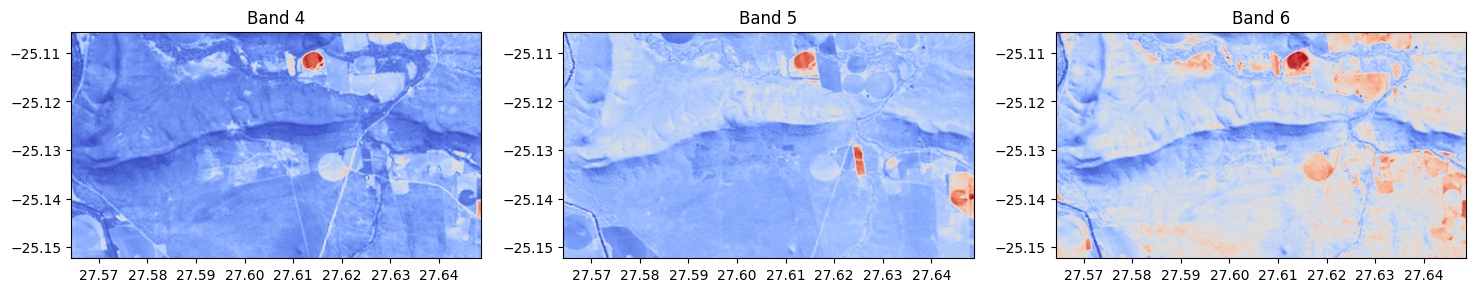

In [ ]:
xmin = assen_data['Longitude'].min()
xmax = assen_data['Longitude'].max()
ymin = assen_data['Latitude'].min()
ymax = assen_data['Latitude'].max()

#Extract the reconstructed bands 5, 6, and 7
reconstructed_band4 = assen_data['ReconstructedBand4'].values.reshape(size)
reconstructed_band5 = assen_data['ReconstructedBand5'].values.reshape(size)
reconstructed_band6 =assen_data['ReconstructedBand6'].values.reshape(size)

#Get the range for each reconstructed band
vmin_band4 = np.min(reconstructed_band4)
vmax_band4 = np.max(reconstructed_band4)
vmin_band5 = np.min(reconstructed_band5)
vmax_band5 = np.max(reconstructed_band5)
vmin_band6 = np.min(reconstructed_band6)
vmax_band6 = np.max(reconstructed_band6)

#Plot reconstructed bands
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 6)

im_band4 = ax[0].imshow(reconstructed_band4, cmap="coolwarm", vmin=vmin_band4, vmax=vmax_band4,
                        extent=[xmin, xmax, ymin, ymax], aspect=1, interpolation='lanczos')
ax[0].set_title('Band 4')

im_band5 = ax[1].imshow(reconstructed_band5, cmap="coolwarm", vmin=vmin_band5, vmax=vmax_band5,
                        extent=[xmin, xmax, ymin, ymax], aspect=1, interpolation='lanczos')
ax[1].set_title('Band 5')

im_band6 = ax[2].imshow(reconstructed_band6, cmap="coolwarm", vmin=vmin_band6, vmax=vmax_band6,
                        extent=[xmin, xmax, ymin, ymax], aspect=1, interpolation='lanczos')
ax[2].set_title('Band 6')

plt.show()